# Hardware lab 1: implementing your control law / Steer by wire

In this first hardware lab we are first going to work without the passive arms of our robot and only focus on the motors. The objective of the lab is to informally play with the motor API and understand the possible issues that can  arise when trying to control accurately a motor.

Concretely, we will play with the notion of Proportional control (discussed in next week's lecture) and use this to reproduce a [steer-by-wire](https://en.wikipedia.org/wiki/Steer-by-wire) system. 



## Preliminaries
First, listen to Garry or Katy for the first few minutes of the lab while they provide some guidance on the platform.

## Communicating with the device
The DICE machines are connected to the platform using a CAN device. This is hidden within a high-level API but you can have a look at the code if you are interested in seeing how all of this works.

To work, open a python console, or edit a file and execute the code that follows. The CAN bus protocol does not work very well with Jupyter notebooks and keyboard interruptions won't work either.



The API is presented in [AROMotorControlAPI.md](https://github.com/ediadvancedrobotics/hardwarelab/blob/main/AROMotorControlAPI.md). The only methods that we need are `readPosition` and `applyTorqueToMotor`.

Each method has a `motorid` parameter, taking the value 1 or 2, which points to the motor that you wish to control.


Therefore, to read the position (joint angle value) or a motor, simply call:



In [2]:
import sys
sys.path.append('/afs/inf.ed.ac.uk/user/s20/s2012077/hardwarelab')

In [6]:
from motor_control.AROMotorControl import AROMotorControl

mc = AROMotorControl()
mc.readPosition(motorid=1)

246.22000000000116

The returned value is an angle value in degrees, between 0 and 360.


## A torque controlled motor
The motor is controlled by sending a current command to it, which results in its rotation. The rotational force produced is called a torque (more on this during the lectures).


### Torque vs current
This paragraph is just for general knowledge. The torque generated is proportional to the current through the relationship $\tau = k I $, with $\tau$ the torque, $I$ the current (in Amperes), and k a constant given by the manufacturer. In our case, the torque constant provided by the [manufacturer](https://www.myactuator.com/product-page/rmd-l-5010) is $0.16$, which trivially gives you $I = \frac{\tau}{0.16}$. We will trust the manufacturer although this might change from a motor to the other (and is yet another source of approximation).


### Sending a command
To send current command you are required to use an exception handling mechanismthat always safely terminates by resetting the control command. Unfortunately this can't be encapsulated in a function as this results in packages loss.

The `run_until` method defined there also allows you to call N times the same method while ensuring an accurate delay `dt` expires before being called again.

Let us use `run_until` to send a constant torque of 0.02 Nm for 2 seconds



In [55]:
from template import run_until

dt = 0.005
N = int(2. / dt)


try:
    run_until(mc.applyTorqueToMotor, N=N, dt=0.005, motorid=1, torque=0.01)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyTorqueToMotor(1, 0)
    mc.applyTorqueToMotor(2, 0)
    print("motors stopped!")

motors stopped!


Lets make a simple plot of the angle value evolution over time while we are sending this command

motors stopped!
400


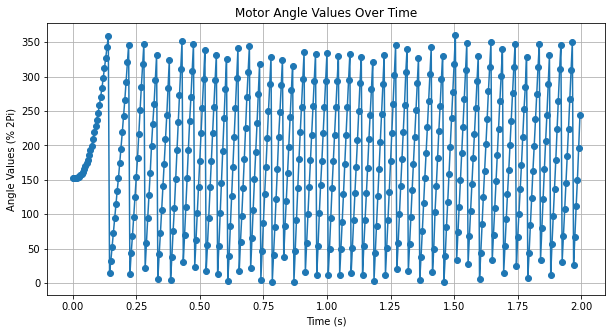

In [62]:
import matplotlib.pyplot as plt

anglevalues =[]

def store_values_and_apply_torques(motorid, torque):
    global anglevalues
    mc.applyTorqueToMotor(motorid=motorid, torque=torque)
    anglevalues+= [mc.readPosition(motorid)]

def store_values(motorid, torque):
    i = 0
    global anglevalues
    if(i<100):
        mc.applyTorqueToMotor(motorid=motorid, torque=torque)
    i += 1
    anglevalues+= [mc.readPosition(motorid)]
    
try:
#     run_until(store_values_and_apply_torques, N=N, dt=0.005, motorid=1, torque=0.02)
    run_until(store_values, N=N, dt=0.005, motorid=1, torque=0.04)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyTorqueToMotor(1, 0)
    mc.applyTorqueToMotor(2, 0)
    print("motors stopped!")
    

    
time_values = [i * dt for i in range(len(anglevalues))]

print(len(anglevalues))
    
# Plotting the angle values
plt.figure(figsize=(10, 5))
plt.plot(time_values, anglevalues, marker='o', linestyle='-')
plt.title('Motor Angle Values Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle Values (% 2Pi)')
plt.grid()
plt.show()

We can observe that as time progresses the angle values change more rapidly, which seems intuitive of course. But we are going to have to deal with these dynamic behaviours as the course progresses.

## Our first control law
Let us know assume that we want the motor to reach a specific angle value target.
We can start by implementing what we call a "proportional" control.
We ll measure the distance between the current position and the target position and apply a torque proportional to that distance. This should remind you of inverse kinematics and least square in general.
For this let's create the class `PController`, for Proportional control.

It is parametrised by a $K_p$ variable that will adjust the strength of the signal sent to the motor.

As there is a lot of friction, we'll need to ensure that a minimal signal is sent when the error is not 0 as the motors tend to not move at all before 0.02 nM. This will be implemented in the `clip` function


In [63]:
def clip(output):
    outabs = abs(output)
    if outabs < 1e-4:
        return 0
    clipped = max(min(outabs, 0.1), 0.02)
    return clipped if output > 0 else -clipped

class PController:
    
    def __init__(self, Kp):
        self.Kp = Kp
                      
    def shortest_path_error(self, target, current):
        diff = ( target - current + 180 ) % 360 - 180;
        if diff < -180:
                diff = diff + 360
        if (current + diff) % 360 == target:
                return diff
        else:
                return -diff
        
    def compute(self, target, current):
        error = self.shortest_path_error(target, current)
        output = self.Kp*error
        return clip(output)
        
        

We can now define a method `goTo` for our first motor, that will apply the control law repeatidly for a given period of time

In [104]:
def goTo(controller, target, time = 1., dt = 0.005, motorid =1):
    anglevalues =[]
    N = (int)(time / dt)
    
    def oneStep():
        nonlocal anglevalues
        currentAngle = mc.readPosition(motorid)
        anglevalues+=[currentAngle]
        tau = controller.compute(target,currentAngle)
        mc.applyTorqueToMotor(motorid,tau)   
        
    run_until(oneStep, N=N, dt=dt)
    
    mc.applyTorqueToMotor(1, 0)
    mc.applyTorqueToMotor(2, 0)
    
    time_values = [i * dt for i in range(len(anglevalues))]
    # Plotting the angle values
    plt.figure(figsize=(10, 5))
    plt.plot(time_values, anglevalues, marker='o', linestyle='-')
    plt.axhline(y=target, color='r', linestyle='--', label='Target Value')  # Add horizontal line for target
    plt.title('Motor Angle Values Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle Values (% 2Pi)')
    plt.grid()
    plt.show()
    
try:
    
    pc = PController(0.00001)
    #goTo(pc, mc.readPosition(motorid=1), time = 1.5, motorid=2)
    while (True):
        #pos = mc.readPosition(motorid=1)
        #au = pc.compute(mc.readPosition(motorid=1),mc.readPosition(motorid=1))
        mc.applyTorqueToMotor(1,pc.compute(mc.readPosition(motorid=1),mc.readPosition(motorid=2)))
        #print(pos)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyTorqueToMotor(1, 0)
    mc.applyTorqueToMotor(2, 0)
    print("motors stopped!")
    

KeyboardInterrupt received, stopping motors...
mismatch!!! msg.aid: 578 aid: 577
msg:Timestamp: 1728573538.438848    ID:      242    S Rx                DL:  8    92 00 00 00 24 e8 3c 00     Channel: can0
motors stopped!


Experiment with different values of $K_p$.
A common issue you will encounter is overshooting, when you go beyond the desired angle and creates an oscillating behaviour:

![title](1/oscillations.png)

This can be compensated somehow by reducing $K_p$, but you then there is a risk of never reaching the target (here represented by the red line):


![title](1/miss.png)


We'll learn next week during the lecture about how these effects can be mitigated. For now, just try to tune the $K_p$ so that this works as best as possible.


## Question
Now, write a 30s control loop that does the following:
+ Motor 1 is configured to track the position of motor 2
+ Motor 2 is configured to track the position of motor 1

Manually mess around with the motors while the loop is running and check that things behave as you expect. A similar system is implemented in some of the recent cars where the steering wheel and the wheels are no longer mechanically connected (see https://en.wikipedia.org/wiki/Steer-by-wire )